# Lesson 6: Advanced chromatographic processes


In this lesson we will learn how to create more complex models with binding, multiple components, and multiple unit operations


### Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [ ]:
%run ../utils.ipynb

## Example 1: Modelling dispersion of valves and tubing

A real system does not have an inlet connected directly to the column which connects directly to the outlet.
Real systems have tubes and mixing valves. 
If they are not accounted for, the pulse that arrives at the column inlet will be far too sharp.
Moreover, the measured output signal from your column will be appear more diffuse than the real column outlet, because it will have spent time in tubing between the outlet and the detector.

We can model this, by introducing additional unit operations that can account for the time shift and dispersion that is introduced by the periphery of the column.
For this example, we will model the mixer at the inlet using a `CSTR`.

In [ ]:
run_simulation(langmuir_model)

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_001.solution_inlet
plt.figure()
plt.plot(time, c)
plt.title('Mixer (Inlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_001.solution_outlet
plt.figure()
plt.plot(time, c)
plt.title('Mixer (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_002.solution_outlet
plt.figure()
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')

## Simulated Moving Bed (Cyclic Systems)

CADET can also simulate much more complex systems. 
We will briefly look over a simulated moving bed example.
Simulated moving bed (SMB) is a system of multiple connected columns, in which a counter-current of the stationary phase is 'simulated' by periodically switching column positions.

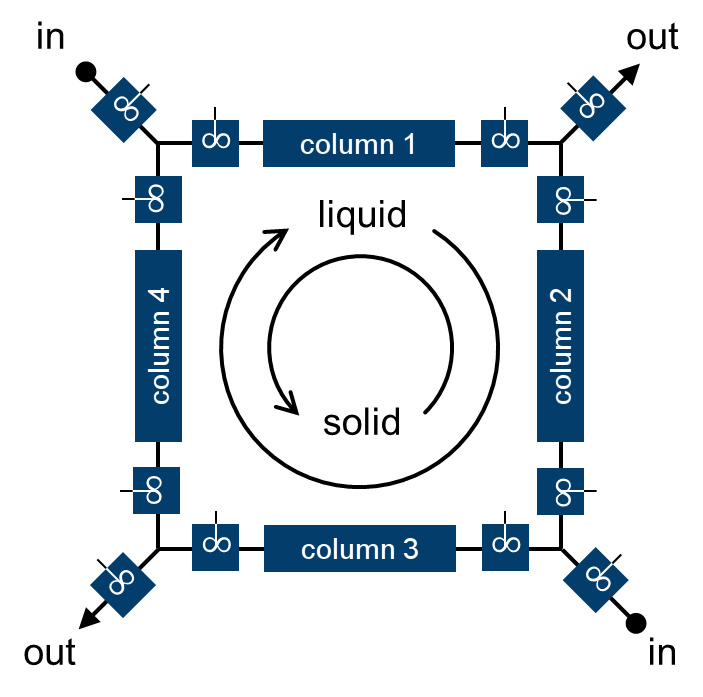

We will briefly look over how these systems are setup but won't go into it in detail.

In [ ]:
# Run simulation and plot results
run_simulation(smb_model)
    

plt.figure()
plt.plot(smb_model.root.output.solution.solution_times,
    smb_model.root.output.solution.unit_002.solution_outlet)
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')
plt.title('Extract')


plt.figure()
plt.plot(smb_model.root.output.solution.solution_times,
    smb_model.root.output.solution.unit_003.solution_outlet)
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')
plt.title('Raffinate')